# Logic Gate Task

This notebook constructs a cTL model to learn several different logic gates without explicit contextualization.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
from IPython.display import clear_output

import tf_utils as tfu

import context_learning as ctl

## Training Strategy

In [3]:
strategy = tfu.strategy.gpu(1)

## Dataset

In [4]:
BATCH_SIZE = 1

In [5]:
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

y_train = np.array([
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 1, 1, 0], # NAND
    [1, 0, 0, 0], # NOR
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 1, 1], # Custom A
    [0, 1, 0, 1], # Custom B
])[..., np.newaxis]

data_labels = [
    "AND",
    "OR",
    "NAND",
    "NOR",
    "XOR",
    "XNOR",
    "Custom A",
    "Custom B"
]

In [6]:
datasets = [] 
for y in y_train:
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y)).batch(BATCH_SIZE)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    datasets.append(dist_dataset)
clear_output() # hide shard warnings

## Model Architecture

In [16]:
def create_model(atr_size=128, switch_threshold=-0.02, num_contexts=8):
    y = x = keras.layers.Input((2,))
    y = keras.layers.Dense(atr_size, activation="relu")(y)
    y = ctl.ContextLayerConvPower(switch_threshold=switch_threshold, num_contexts=2, verbose=0)(y)
    y = keras.layers.Dense(atr_size, activation="relu")(y)
    y = ctl.ContextLayerConvPower(switch_threshold=switch_threshold, num_contexts=4, verbose=0)(y)
    y = keras.layers.Dense(1, activation="sigmoid")(y)
    model = ctl.ContextModel(x, y, verbose=1)
    model.compile(
        optimizer=keras.optimizers.SGD(1e-1),
        loss=keras.losses.BinaryCrossentropy(from_logits=False))
    return model

## Training

In [17]:
EPOCHS_PER_TASK = 50
REPITIONS = 4

NUM_CONTEXTS = 8
SWITCH_THRESHOLD = -0.02
ATR_SIZE = 128

In [20]:
model.context_layer_map

ListWrapper([2, 4])

In [23]:
with strategy.scope():
    train = ctl.make_train_function(eager=False)
    model = create_model(ATR_SIZE, SWITCH_THRESHOLD, NUM_CONTEXTS)
    
    history = {
        "loss": [],
        "context_loss": {i: [] for i in model.context_layer_map},
        "context_delta": {i: [] for i in model.context_layer_map},
    }

    epoch = -1
    for _ in range(REPITIONS):
        for i in np.random.permutation(NUM_CONTEXTS):
            dataset = datasets[i]
            start = epoch + 1
            print("\nDataset:", i)
            for epoch in range(start, epoch+EPOCHS_PER_TASK + 1):
                while model.perform_epoch(epoch):
                    history["loss"].append(0)
                    for batch in dataset:
                        loss = train(strategy, model, batch)
                        history["loss"][-1] += loss
                    print(f"\rEpoch: {epoch}; Task Epoch:{epoch - start + 1}; Dataset: {i}; Loss: {loss}", end="")
                for i in model.context_layer_map:
                    history["context_loss"][i].append(model.layers[i].context_losses.value())
                    history["context_delta"][i].append(model.layers[i].delta.value())


Dataset: 5
Epoch: 49; Task Epoch:50; Dataset: 4; Loss: 0.008052732795476913
Dataset: 3
Epoch: 99; Task Epoch:50; Dataset: 4; Loss: 0.0013598888181149965
Dataset: 4
Epoch: 100; Task Epoch:1; Dataset: 4; Loss: 2.1497631072998047Switching to best-fit context: 0
Epoch: 100; Task Epoch:1; Dataset: 4; Loss: 2.1497631072998047Switching to best-fit context: 0
Epoch: 100; Task Epoch:1; Dataset: 4; Loss: 2.1497631072998047Switching to best-fit context: 0
Epoch: 149; Task Epoch:50; Dataset: 4; Loss: 0.0030389279127120977
Dataset: 2
Epoch: 150; Task Epoch:1; Dataset: 2; Loss: 2.083772659301758Switching to best-fit context: 0
Epoch: 150; Task Epoch:1; Dataset: 2; Loss: 1.396807074546814Switching to best-fit context: 0
Epoch: 150; Task Epoch:1; Dataset: 2; Loss: 1.396807074546814Switching to best-fit context: 0
Epoch: 199; Task Epoch:50; Dataset: 4; Loss: 0.0034808388445526367
Dataset: 1
Epoch: 200; Task Epoch:1; Dataset: 1; Loss: 0.00860701035708189Switching to best-fit context: 0
Epoch: 200; Task

2022-03-13 04:18:32.927756: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 399; Task Epoch:50; Dataset: 4; Loss: 0.0012622729409486055
Dataset: 5
Epoch: 400; Task Epoch:1; Dataset: 5; Loss: 5.115564823150635Switching to best-fit context: 0
Epoch: 400; Task Epoch:1; Dataset: 5; Loss: 0.665382444858551Switching to best-fit context: 1
Epoch: 400; Task Epoch:1; Dataset: 5; Loss: 2.4486124515533447Switching to best-fit context: 0
Switching to best-fit context: 0
Epoch: 400; Task Epoch:1; Dataset: 5; Loss: 0.0008161968435160816Switching to best-fit context: 0
Epoch: 400; Task Epoch:1; Dataset: 5; Loss: 0.0008161968435160816Switching to best-fit context: 0
Epoch: 449; Task Epoch:50; Dataset: 4; Loss: 0.0009021065197885036
Dataset: 0
Epoch: 450; Task Epoch:1; Dataset: 0; Loss: 5.15748405456543Switching to best-fit context: 0
Epoch: 450; Task Epoch:1; Dataset: 0; Loss: 0.3895016312599182Switching to best-fit context: 1
Epoch: 450; Task Epoch:1; Dataset: 0; Loss: 1.9759637117385864Switching to best-fit context: 0
Switching to best-fit context: 0
Epoch: 450; Task

2022-03-13 04:19:02.977630: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 849; Task Epoch:50; Dataset: 4; Loss: 7.81659473432228e-0559
Dataset: 6
Epoch: 850; Task Epoch:1; Dataset: 6; Loss: 0.37456420063972473Switching to best-fit context: 1
Epoch: 850; Task Epoch:1; Dataset: 6; Loss: 0.059799470007419586Switching to best-fit context: 3
Epoch: 850; Task Epoch:1; Dataset: 6; Loss: 7.405470848083496Switching to best-fit context: 1
Switching to best-fit context: 0
Epoch: 850; Task Epoch:1; Dataset: 6; Loss: 0.059799470007419586Switching to best-fit context: 1
Switching to best-fit context: 0
Epoch: 850; Task Epoch:1; Dataset: 6; Loss: 0.059799470007419586Switching to best-fit context: 1
Switching to best-fit context: 0
Epoch: 899; Task Epoch:50; Dataset: 4; Loss: 0.0011703759664669633
Dataset: 4
Epoch: 900; Task Epoch:1; Dataset: 4; Loss: 6.2540411949157715Switching to best-fit context: 1
Epoch: 900; Task Epoch:1; Dataset: 4; Loss: 0.12256725877523422Switching to best-fit context: 1
Epoch: 900; Task Epoch:1; Dataset: 4; Loss: 7.033608913421631Switching t

2022-03-13 04:19:32.988266: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch: 1299; Task Epoch:50; Dataset: 4; Loss: 0.0043288231827318674
Dataset: 3
Epoch: 1300; Task Epoch:1; Dataset: 3; Loss: 0.0012283510295674205Switching to best-fit context: 0
Epoch: 1300; Task Epoch:1; Dataset: 3; Loss: 0.012838699854910374Switching to best-fit context: 0
Epoch: 1300; Task Epoch:1; Dataset: 3; Loss: 0.48354750871658325Switching to best-fit context: 0
Switching to best-fit context: 1
Epoch: 1300; Task Epoch:1; Dataset: 3; Loss: 0.012838699854910374Switching to best-fit context: 0
Switching to best-fit context: 1
Epoch: 1300; Task Epoch:1; Dataset: 3; Loss: 0.012838699854910374Switching to best-fit context: 0
Switching to best-fit context: 1
Epoch: 1300; Task Epoch:1; Dataset: 3; Loss: 0.012838699854910374Switching to best-fit context: 1
Epoch: 1349; Task Epoch:50; Dataset: 4; Loss: 0.0009090837556868792
Dataset: 1
Epoch: 1350; Task Epoch:1; Dataset: 1; Loss: 5.020970821380615Switching to best-fit context: 1
Epoch: 1350; Task Epoch:1; Dataset: 1; Loss: 0.0323515422642

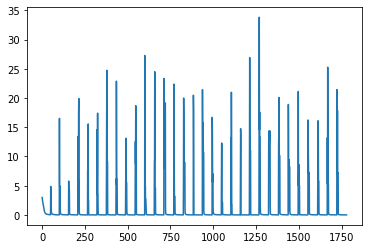

In [26]:
plt.plot(history["loss"])

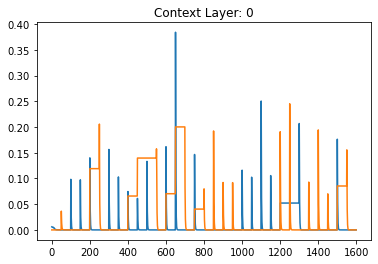

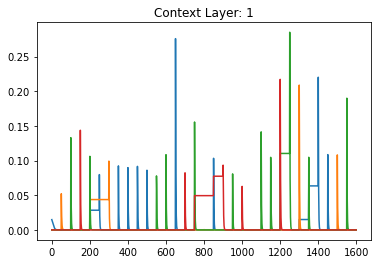

In [30]:
for i, layer_id in enumerate(model.context_layer_map):
    for ctx in np.array(history["context_loss"][layer_id]).T:
        plt.plot(ctx)
    plt.title(f"Context Layer: {i}")
    plt.show()

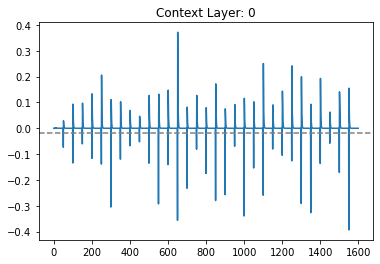

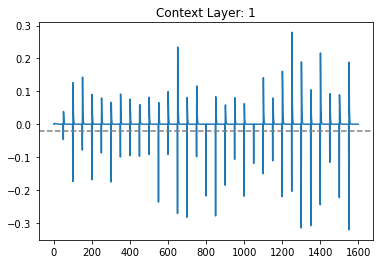

In [37]:
for i, layer_id in enumerate(model.context_layer_map):
    plt.title(f"Context Layer: {i}")
    plt.plot(history["context_delta"][layer_id])
    plt.axhline(y=model.layers[layer_id].switch_threshold.value(), color="gray", linestyle="--")
    plt.show()

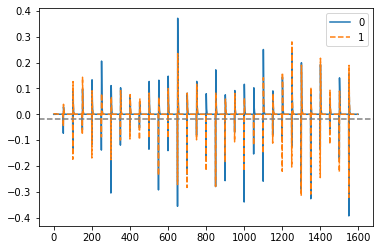

In [60]:
for i, layer_id in enumerate(model.context_layer_map):
    plt.plot(history["context_delta"][layer_id], linestyle="--" if i == 1 else None)
plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")
plt.legend(np.arange(2))

In [ ]:
plt.plot(history["context_delta"])
plt.axhline(y=model.layers[2].switch_threshold.value(), color="gray", linestyle="--")

## Evaluation:

The following cell is a rough but quick evaluation of the model, looking for contexts that have fully learned a gate. This method of evaulation should not be used in actual experiments and will be replaced later.

In [16]:
total = 0
for ctx in range(NUM_CONTEXTS):
    model.layers[2].set_context(ctx)
    pred = (model(x_train).numpy() >= 0.5).astype(dtype=np.int32)
    for i in range(len(y_train)):
        if np.all(pred == y_train[i]):
            total += 1
print(f"Accuarcy: {100*total/NUM_CONTEXTS}%")

Accuarcy: 100.0%
